In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from flask import Flask, render_template, request
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

[0]	validation_0-logloss:0.62287
[83]	validation_0-logloss:0.22774
Accuracy: 0.8935600481992234

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      3401
           1       0.90      0.91      0.90      4068

    accuracy                           0.89      7469
   macro avg       0.89      0.89      0.89      7469
weighted avg       0.89      0.89      0.89      7469



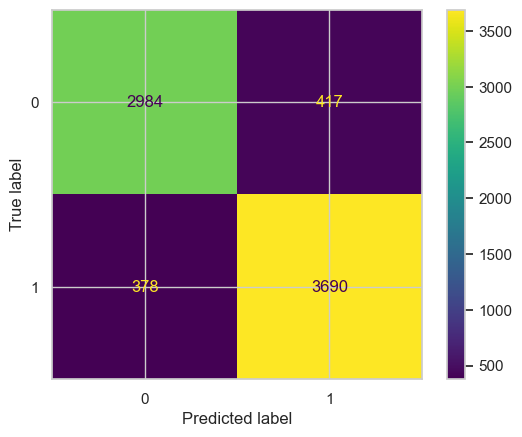

Best Iteration: 73
Mean Training Accuracy across 30 bootstraps: 0.9169969648277093
Mean Training Recall across 30 bootstraps: 0.9424000222018704
Mean Test Accuracy across 30 bootstraps: 0.8921720890793055
Mean Test Recall across 30 bootstraps: 0.9173303834808259
Cross-Validation Scores: [0.89355055 0.89355055 0.89020308 0.898237   0.89241071]
Mean CV Score: 0.8935903776261677
Mean Squared Error on Holdout Set: 0.10349444370062927
Mean Squared Error on Training Set: 0.08266381003392251


In [33]:
# XGBoost model

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])

target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()

# Split the data into features and target variable
X = df_encoded.drop(columns=[target_variable])
y = df_encoded[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create an XGBoost classifier
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='binary:logistic')

# Train the model on the training set
model.fit(X_train, y_train, eval_metric='logloss', eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

# Best interation
best_iteration = model.best_iteration
print(f"Best Iteration: {best_iteration}")

## Bootstrapping

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
train_recall_values = []
test_accuracy_values = []
test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_accuracy_values.append(train_accuracy)
    train_recall_values.append(train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy_values.append(test_accuracy)
    test_recall_values.append(test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)

print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")

from sklearn.model_selection import StratifiedKFold, cross_val_score

## K-Fold CV

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

Training on fold [0/5]
0:	learn: 0.5836250	test: 0.5838462	best: 0.5838462 (0)	total: 45.6ms	remaining: 4.52s
1:	learn: 0.5006914	test: 0.5014199	best: 0.5014199 (1)	total: 89.8ms	remaining: 4.4s
2:	learn: 0.4453561	test: 0.4465566	best: 0.4465566 (2)	total: 133ms	remaining: 4.32s
3:	learn: 0.4042011	test: 0.4058780	best: 0.4058780 (3)	total: 189ms	remaining: 4.54s
4:	learn: 0.3780412	test: 0.3794965	best: 0.3794965 (4)	total: 230ms	remaining: 4.36s
5:	learn: 0.3512696	test: 0.3534556	best: 0.3534556 (5)	total: 271ms	remaining: 4.24s
6:	learn: 0.3363849	test: 0.3389889	best: 0.3389889 (6)	total: 309ms	remaining: 4.11s
7:	learn: 0.3196872	test: 0.3227914	best: 0.3227914 (7)	total: 352ms	remaining: 4.05s
8:	learn: 0.3055983	test: 0.3087332	best: 0.3087332 (8)	total: 394ms	remaining: 3.98s
9:	learn: 0.2984741	test: 0.3013727	best: 0.3013727 (9)	total: 442ms	remaining: 3.98s
10:	learn: 0.2924146	test: 0.2956453	best: 0.2956453 (10)	total: 484ms	remaining: 3.92s
11:	learn: 0.2763249	test: 0

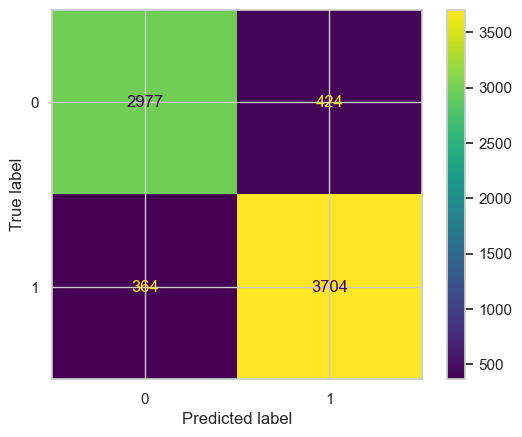


Overfitting Detector: 0.98989898989899
0:	learn: 0.6334596	total: 27.3ms	remaining: 2.71s
1:	learn: 0.5847737	total: 61.8ms	remaining: 3.03s
2:	learn: 0.5412210	total: 90.8ms	remaining: 2.93s
3:	learn: 0.5052889	total: 117ms	remaining: 2.81s
4:	learn: 0.4745463	total: 144ms	remaining: 2.73s
5:	learn: 0.4491152	total: 171ms	remaining: 2.69s
6:	learn: 0.4266908	total: 199ms	remaining: 2.64s
7:	learn: 0.4077904	total: 226ms	remaining: 2.6s
8:	learn: 0.3926029	total: 254ms	remaining: 2.57s
9:	learn: 0.3777005	total: 288ms	remaining: 2.59s
10:	learn: 0.3649363	total: 316ms	remaining: 2.56s
11:	learn: 0.3530898	total: 345ms	remaining: 2.53s
12:	learn: 0.3450593	total: 374ms	remaining: 2.5s
13:	learn: 0.3361499	total: 408ms	remaining: 2.51s
14:	learn: 0.3288059	total: 444ms	remaining: 2.51s
15:	learn: 0.3236321	total: 478ms	remaining: 2.51s
16:	learn: 0.3174596	total: 520ms	remaining: 2.54s
17:	learn: 0.3079865	total: 557ms	remaining: 2.54s
18:	learn: 0.3000382	total: 591ms	remaining: 2.52s


In [34]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder

## CatBoost model

# Load dataset, drop irrelevant columns, remove minus numerical values and label encode where necessary
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])


target_variable = 'churn'

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Split the data into features and target variable
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a CatBoost classifier
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', cat_features=categorical_features)

# Use cross-validation with the train-test split
cv_params = model.get_params()
cv_data = cv(Pool(X, y, cat_features=categorical_features), cv_params, fold_count=5)

# Train the model on the training set
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

# Overfitting detector
overfitting_detector = model.get_best_iteration() / (cv_data.shape[0] - 1)

print(f"\nOverfitting Detector: {overfitting_detector}")

## Bootstrapping

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

# Number of bootstrap samples
num_bootstraps = 30

# Initialize empty lists to store accuracy and recall values for training and test sets
train_accuracy_values = []
train_recall_values = []
test_accuracy_values = []
test_recall_values = []

# Bootstrap loop
for _ in range(num_bootstraps):
    # Create a bootstrap sample for training
    bootstrap_sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap_train = X_train.iloc[bootstrap_sample_indices]
    y_bootstrap_train = y_train.iloc[bootstrap_sample_indices]

    model.fit(X_bootstrap_train, y_bootstrap_train)

    # Evaluate the model on the fixed training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_accuracy_values.append(train_accuracy)
    train_recall_values.append(train_recall)

    # Evaluate the model on the fixed test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy_values.append(test_accuracy)
    test_recall_values.append(test_recall)

# Calculate means for training and test sets
mean_train_accuracy = np.mean(train_accuracy_values)
mean_train_recall = np.mean(train_recall_values)
mean_test_accuracy = np.mean(test_accuracy_values)
mean_test_recall = np.mean(test_recall_values)

print(f"Mean Training Accuracy across {num_bootstraps} bootstraps: {mean_train_accuracy}")
print(f"Mean Training Recall across {num_bootstraps} bootstraps: {mean_train_recall}")
print(f"Mean Test Accuracy across {num_bootstraps} bootstraps: {mean_test_accuracy}")
print(f"Mean Test Recall across {num_bootstraps} bootstraps: {mean_test_recall}")

## K-Fold CV

from sklearn.model_selection import StratifiedKFold, cross_val_score

k_folds = 5
stratified_cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print or use the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

## Validation with holdout data set

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42)

# Make predictions on the holdout set
y_pred_holdout = model.predict(X_holdout)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Evaluate the model on the holdout set
mse_holdout = mean_squared_error(y_holdout, y_pred_holdout)
print(f'Mean Squared Error on Holdout Set: {mse_holdout}')

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'Mean Squared Error on Training Set: {mse_train}')

In [35]:
df = pd.read_csv('churn.csv')
df.drop(['referral_id'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df = df.loc[(df[numerical_columns] >= 0).all(axis=1)]
df.dropna(inplace=True)
df['age'] = LabelEncoder().fit_transform(df['age'])
df['joining_date'] = LabelEncoder().fit_transform(df['joining_date'])
df['last_visit_time'] = LabelEncoder().fit_transform(df['last_visit_time'])
df['days_since_last_login'] = LabelEncoder().fit_transform(df['days_since_last_login'])
df['avg_time_spent'] = LabelEncoder().fit_transform(df['avg_time_spent'])
df['opportunity_size_usd'] = LabelEncoder().fit_transform(df['opportunity_size_usd'])
df['avg_frequency_login_days'] = LabelEncoder().fit_transform(df['avg_frequency_login_days'])
df['points_in_wallet'] = LabelEncoder().fit_transform(df['points_in_wallet'])
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Convert non-numeric columns to numeric
for column in df_encoded.columns:
    if df_encoded[column].dtype == 'object':
        df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop rows with missing values (NaNs) after conversion
df_encoded = df_encoded.dropna()
print(df_encoded.dtypes)

class_counts = df['churn'].value_counts()
print(class_counts)

total_instances = len(df)

class_balances = class_counts / total_instances * 100
print("Class Balances:")
print(class_balances)

age                                                int64
joining_date                                       int32
last_visit_time                                    int32
days_since_last_login                              int64
avg_time_spent                                     int64
opportunity_size_usd                               int64
avg_frequency_login_days                           int32
points_in_wallet                                   int64
churn                                              int64
technology_primary_Analytics                        bool
technology_primary_ERP Implementation               bool
technology_primary_Legacy Modernization             bool
technology_primary_Technical Business Solutions     bool
joined_through_referral_?                           bool
joined_through_referral_No                          bool
joined_through_referral_Yes                         bool
preferred_offer_types_Credit/Debit Card Offers      bool
preferred_offer_types_Gift Vouc